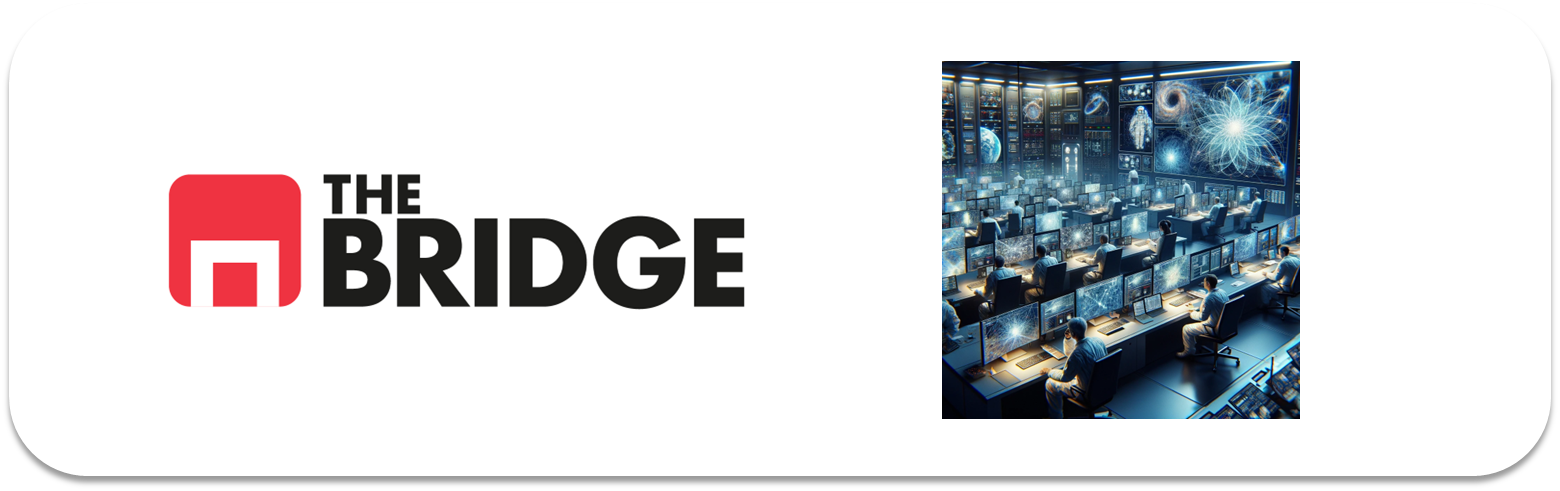

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
from skimage.io import imread
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [96]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [97]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [98]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) 

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [99]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


In [100]:
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)

X test shape:  (3000, 32, 32, 3)
Y test shape:  (3000,)


Text(0.5, 1.0, 'buildings')

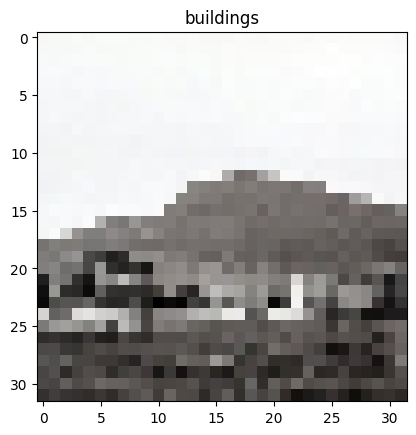

In [101]:
plt.imshow(X_train[0])
plt.title(y_train[0])

Text(0.5, 1.0, 'buildings')

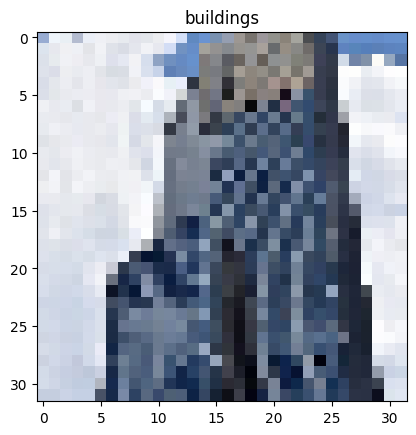

In [102]:
plt.imshow(X_test[0])
plt.title(y_test[0])

In [103]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisajes in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisajes)
        plt.axis("off")
        if len(names):
            plt.title(names[index])

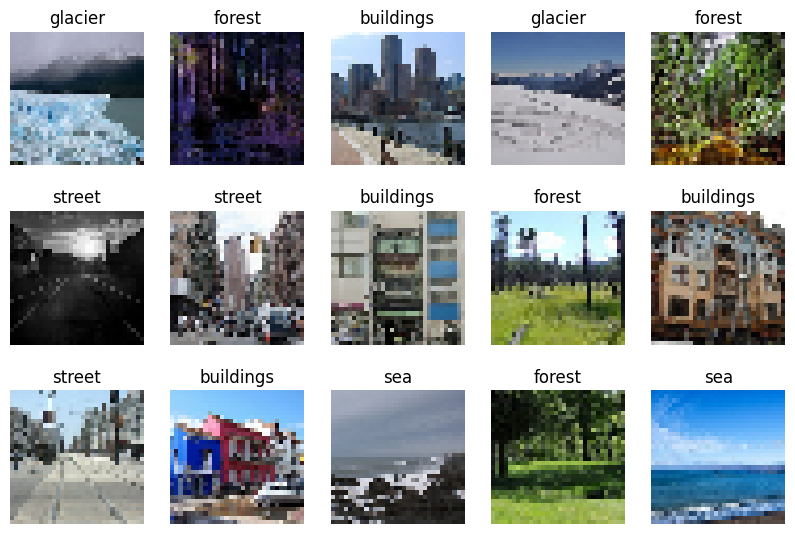

In [104]:
indices = np.random.randint(0,len(X_train),15)
show_images_batch(X_train[indices], y_train[indices])

In [105]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

El análisis de la variable objetivo muestra una distribución relativamente balanceada entre las seis categorías de imágenes, con proporciones que oscilan entre el 15.6% y el 17.9%. La clase "mountain" es la más representada con un 17.9%, mientras que "buildings" es la menos frecuente con un 15.6%.

In [106]:
X_train = X_train/255
X_test = X_test/255

In [107]:
# Barajamos los datos, nos interesa hacerlo con train puesto que son a partir de los cuales aprende el modelo
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)

In [108]:
# Maopeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [109]:
mapping

{np.str_('buildings'): 0,
 np.str_('forest'): 1,
 np.str_('glacier'): 2,
 np.str_('mountain'): 3,
 np.str_('sea'): 4,
 np.str_('street'): 5}

In [110]:
inverse_mapping

{0: np.str_('buildings'),
 1: np.str_('forest'),
 2: np.str_('glacier'),
 3: np.str_('mountain'),
 4: np.str_('sea'),
 5: np.str_('street')}

In [111]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

### Transfer-learning

In [112]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights="imagenet", pooling='avg')

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,646,197 (10.09 MB)

 Trainable params: 388,213 (1.48 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [113]:
earlyS = EarlyStopping(patience= 5, restore_best_weights= True)

In [114]:
X_train_s.shape

(14034, 32, 32, 3)

In [115]:
y_train_num.shape

(14034,)

In [116]:
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = 64,
                    validation_split=0.2,
                    epochs=20,
                   callbacks=[earlyS])

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - acc: 0.3663 - loss: 1.8835 - val_acc: 0.4916 - val_loss: 1.2876
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - acc: 0.4855 - loss: 1.2896 - val_acc: 0.5116 - val_loss: 1.2378
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - acc: 0.5161 - loss: 1.2300 - val_acc: 0.5134 - val_loss: 1.2203
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - acc: 0.5287 - loss: 1.2024 - val_acc: 0.5176 - val_loss: 1.2089
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - acc: 0.5235 - loss: 1.2050 - val_acc: 0.5187 - val_loss: 1.2022
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - acc: 0.5351 - loss: 1.1818 - val_acc: 0.5233 - val_loss: 1.1928
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - acc: 0.5426 - loss: 1.1553 - val_acc: 0.5201 - val_loss: 1.1951
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - acc: 0.5601 - loss: 1.1347 - val_acc: 0.5219 - val_loss: 1.1917
Epoch 9/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 5

El modelo muestra poco aprendizaje generalizable con tendencia a estancamiento. Para datasets con muchas clases y pocas imágenes, una arquitectura más ligera, más resolución o transferencia de conocimiento desde modelos preentrenados a 64x64 suelen ser las mejores estrategias.

### El modelo logra un rendimiento aceptable (75% accuracy), pero aún tiene margen de mejora. 

In [117]:
evol = pd.DataFrame(history.history)

<Axes: >

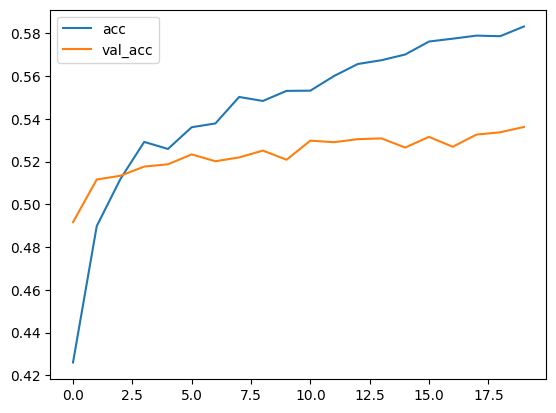

In [118]:
evol[["acc","val_acc"]].plot()

<Axes: >

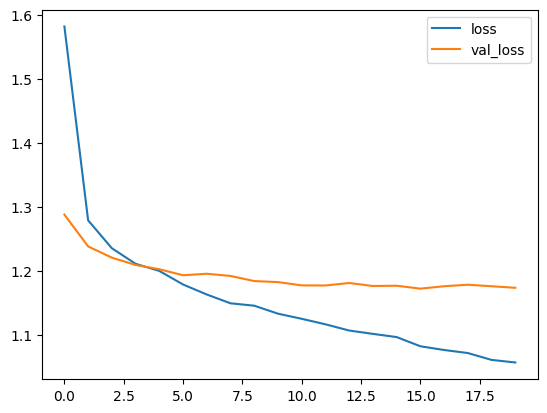

In [119]:
evol[["loss","val_loss"]].plot()

In [120]:
# Evaluamos el modelo
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.5605 - loss: 1.1436


[1.1835651397705078, 0.531000018119812]

In [121]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step
              precision    recall  f1-score   support

   buildings       0.53      0.51      0.52       437
      forest       0.76      0.83      0.80       474
     glacier       0.47      0.38      0.42       553
    mountain       0.44      0.54      0.48       525
         sea       0.51      0.47      0.49       510
      street       0.48      0.49      0.49       501

    accuracy                           0.53      3000
   macro avg       0.53      0.54      0.53      3000
weighted avg       0.53      0.53      0.53      3000



El modelo muestra un rendimiento general bajo (53%) con fuertes diferencias entre clases. Clasifica correctamente escenarios más definidos como forest, pero falla significativamente en clases visualmente más similares o con menos información discriminativa (glacier, mountain, sea). El comportamiento sugiere que el modelo actual no capta suficientes patrones visuales distintivos, posiblemente por baja resolución, pocas muestras por clase o una arquitectura demasiado pesada para el tamaño de imagen.

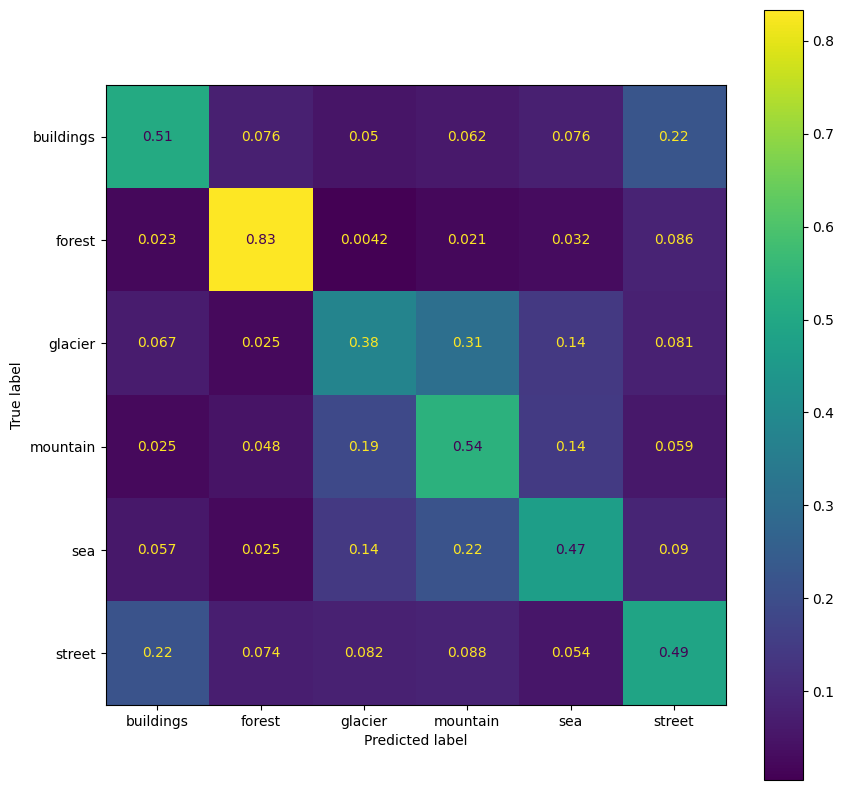

In [122]:
fig,axs = plt.subplots(1,1,figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

### Fine Tuning

In [123]:
# Cargamos el modelo pre-entrenado
base_model = MobileNetV2(include_top=False, weights=None, input_shape=(32, 32, 3))

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 2,646,197 (10.09 MB)

 Trainable params: 2,612,085 (9.96 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [129]:
earlySFT = EarlyStopping(restore_best_weights= True, patience= 5)

In [130]:
# Entrenamos el modelo
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = 64,
                    validation_split=0.2,
                    epochs=10,
                   callbacks= earlySFT)
print(time() - t_zero)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 277ms/step - acc: 0.8339 - loss: 0.6319 - val_acc: 0.5721 - val_loss: 1.2969
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 262ms/step - acc: 0.8867 - loss: 0.3498 - val_acc: 0.5518 - val_loss: 3.1805
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - acc: 0.7937 - loss: 0.6285 - val_acc: 0.5305 - val_loss: 2.6262
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 262ms/step - acc: 0.8855 - loss: 0.3535 - val_acc: 0.7086 - val_loss: 1.9106
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 50s 284ms/step - acc: 0.9050 - loss: 0.2889 - val_acc: 0.6370 - val_loss: 2.6874
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 492ms/step - acc: 0.9162 - loss: 0.2540 - val_acc: 0.6744 - val_loss: 2.6380
349.3809630870819


El modelo muestra una estructura adecuada para tareas multiclase, aunque sus resultados pueden verse limitados por la ausencia de transferencia de conocimiento y la resolución baja. Para mejorar significativamente la precisión general y la estabilidad por clase, se recomienda emplear pesos preentrenados, imágenes de mayor tamaño (64×64 o más) y considerar un fine-tuning progresivo descongelando las últimas capas de MobileNetV2 tras un preentrenamiento inicial.

<Axes: >

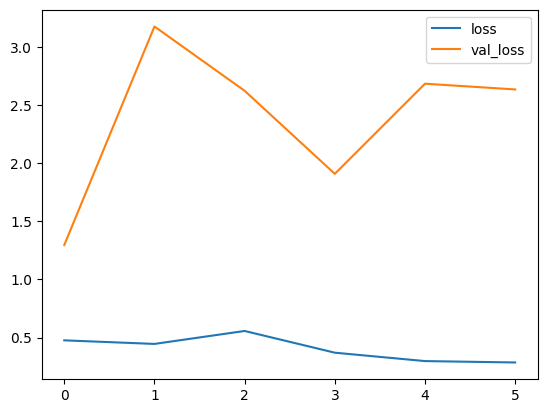

In [131]:
df_evol = pd.DataFrame(history.history)
df_evol[["loss","val_loss"]].plot()

In [132]:
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.5415 - loss: 1.4300


[1.361077070236206, 0.5609999895095825]

In [133]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step
              precision    recall  f1-score   support

   buildings       0.61      0.62      0.61       437
      forest       0.97      0.53      0.69       474
     glacier       0.78      0.42      0.55       553
    mountain       0.80      0.17      0.28       525
         sea       0.37      0.91      0.53       510
      street       0.59      0.75      0.66       501

    accuracy                           0.56      3000
   macro avg       0.69      0.57      0.55      3000
weighted avg       0.69      0.56      0.55      3000



###  Conclusión del Modelo de Clasificación Multiclase

El modelo de clasificación basado en MobileNetV2 logró un rendimiento general moderado, alcanzando una accuracy del 56% y un F1-score macro promedio del 55% en el conjunto de prueba. Aunque se observaron resultados aceptables en algunas clases como buildings y street, el rendimiento fue muy desigual entre categorías. Clases como forest y mountain presentaron un desequilibrio marcado entre precisión y recall, evidenciando que el modelo acierta únicamente en los casos más obvios, pero falla en generalizar sobre ejemplos más difíciles.